In [1]:
import os
import zarr
import timm
import random
import json
import gc
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict

import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from tqdm import tqdm
from src.kaggle_notebook_metric import compute_lb, extract_particle_results
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

import wandb
from pathlib import Path

notebook_name = os.path.join(Path().resolve()).split("/")[-1]

param = {
    "model": CFG.model_name,
    "resolution": CFG.resolution,
    "augmentation_prob": CFG.augmentation_prob,
    "slice": CFG.slice_,
    "epochs": CFG.epochs,
    "lr": CFG.lr,
    "batch_size": CFG.batch_size,
    "weight_decay": CFG.weight_decay,
    "num_workers": CFG.num_workers,
    "augment_data_ratio": CFG.augment_data_ratio,
}

In [2]:
from sklearn.metrics import *
from scipy.optimize import minimize

# sikii値とexp_namesを入れるとスコアを出力する関数


def compute_score(sikii_list, inferenced_array, exp_name):
    apo_ferritin = sikii_list[0]
    beta_amylase = sikii_list[1]
    beta_galactosidase = sikii_list[2]
    ribosome = sikii_list[3]
    thyroglobulin = sikii_list[4]
    virus_like_particle = sikii_list[5]

    sikii_dict = {
        "apo-ferritin": apo_ferritin,
        "beta-amylase": beta_amylase,
        "beta-galactosidase": beta_galactosidase,
        "ribosome": ribosome,
        "thyroglobulin": thyroglobulin,
        "virus-like-particle": virus_like_particle,
    }

    all_pred = []

    pred_df = inference2pos(
        pred_segmask=inferenced_array, exp_name=exp_name, sikii_dict=sikii_dict
    )

    all_pred.append(pred_df)

    gc.collect()

    pred_df = pd.concat(all_pred, axis=0).reset_index(drop=True)
    pred_df = pred_df[pred_df["particle_type"] != "beta-amylase"]
    pred_df = pred_df.drop_duplicates(
        subset=["experiment", "x", "y", "z"], keep="first"
    ).reset_index(drop=True)
    pred_df = pred_df.reset_index().rename(columns={"index": "id"})

    gt_df = create_gt_df("../../inputs/train/overlay/ExperimentRuns/", [exp_name])

    result_df, lb_score = compute_lb(
        pred_df, "../../inputs/train/overlay/ExperimentRuns/", [exp_name]
    )

    return lb_score


def reduce_computation_sikii_search(
    inferenced_array: np.ndarray, exp_name: str, threshold_candidates: list[float]
) -> tuple[list[float], float]:
    """
    # How
    6つのしきい値が互いに独立してスコアに貢献しているという前提で、
    1次元ずつ最適なしきい値を探す手法を実装する.

    1. 初期の best_thresholds (全要素 0.5 など適当な値) を用意
    2. i=0 から i=5 まで順番に:
       - threshold_candidates をすべて試し、他は固定したまま i 番目だけ変化させてスコアを計算
       - 最良スコアが得られる候補値を確定し、best_thresholds[i] とする
    3. 全部決まったら最終的なスコアを計算して返す

    これにより、全組み合わせ (product) を回すよりも計算量が大幅に減少する.
    """
    # Why not: 6値独立であるという前提が満たされていない場合、近似解になる可能性あり
    best_thresholds = [0.5] * 6  # 適当な初期値でOK

    for i in tqdm(range(6)):
        best_local_score = -float("inf")
        best_local_value = None

        for candidate in threshold_candidates:
            current_thresholds = best_thresholds[:]  # 現在のベストを複製
            current_thresholds[i] = candidate
            score = compute_score(current_thresholds, inferenced_array, exp_name)
            if score > best_local_score:
                best_local_score = score
                best_local_value = candidate

        # i番目のしきい値を最適値に更新
        best_thresholds[i] = best_local_value

    final_score = compute_score(best_thresholds, inferenced_array, exp_name)
    return best_thresholds, final_score

In [3]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = mixup(
    #         tomogram, segmentation_map, alpha=mixup_alpha
    #     )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 256, 256])


In [4]:
from transformers import get_cosine_schedule_with_warmup

In [5]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [6]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor


padf = PadToSize(CFG.resolution)

In [7]:
for vaild_exp_name in ["TS_73_6", "TS_99_9", "TS_6_4", "TS_69_2", "TS_86_3", "TS_6_6"]:
    wandb.init(
        project="czii2024", name=f"{notebook_name}_{vaild_exp_name}", config=param
    )

    vaild_exp_name = [vaild_exp_name]
    train_exp_name = CFG.train_exp_names.copy()
    train_exp_name.remove(vaild_exp_name[0])

    # valid_exp_name[0]の名前でディレクトリを作成
    os.makedirs(f"./{vaild_exp_name[0]}", exist_ok=True)

    train_dataset = EziiDataset(
        exp_names=train_exp_name,
        base_dir="../../inputs/train/",
        particles_name=CFG.particles_name,
        resolution=CFG.resolution,
        zarr_type=CFG.train_zarr_types,
        train=True,
        augmentation=True,
        slice=True,
        pre_read=True,
    )
    valid_dataset = EziiDataset(
        exp_names=vaild_exp_name,
        base_dir="../../inputs/train/",
        particles_name=CFG.particles_name,
        resolution=CFG.resolution,
        zarr_type=CFG.valid_zarr_types,
        augmentation=False,
        train=True,
        slice=True,
        pre_read=True,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=CFG.num_workers,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
        num_workers=CFG.num_workers,
    )

    encoder = timm.create_model(
        model_name=CFG.model_name,
        pretrained=True,
        in_chans=3,
        num_classes=0,
        global_pool="",
        features_only=True,
    )
    model = Unet3D(encoder=encoder, num_domains=5).to("cuda")

    optimizer = torch.optim.Adam(
        model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
    )
    criterion = DiceLoss()
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=10,
        num_training_steps=CFG.epochs * len(train_loader),
        # * batch_size,
    )
    scaler = GradScaler()
    seg_loss = SegmentationLoss(criterion)
    padf = PadToSize(CFG.resolution)

    best_model = None
    best_constant = 0
    best_score = -100
    best_particle_score = {}

    grand_train_loss = []
    grand_valid_loss = []
    grand_train_score = []
    grand_valid_score = []

    for epoch in range(CFG.epochs):
        model.train()
        train_loss = []
        valid_loss = []
        with tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]"
        ) as tq:
            for data in tq:
                normalized_tomogram = data["normalized_tomogram"]
                segmentation_map = data["segmentation_map"]
                zarr_embedding_idx = data["zarr_type_embedding_idx"]

                normalized_tomogram = padf(normalized_tomogram)
                segmentation_map = padf(segmentation_map)

                # データ拡張
                normalized_tomogram, segmentation_map = augment_data(
                    normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
                )
                normalized_tomogram = normalized_tomogram.cuda()
                segmentation_map = segmentation_map.long().cuda()
                zarr_embedding_idx = zarr_embedding_idx.cuda()

                optimizer.zero_grad()

                with autocast():
                    pred = model(
                        preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                    )
                    loss = seg_loss(pred, segmentation_map)
                # loss.backward()
                # optimizer.step()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                train_loss.append(loss.item())

                # 確率予測
                prob_pred = torch.softmax(pred, dim=1)
                tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

        del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
        gc.collect()
        torch.cuda.empty_cache()

        with tqdm(
            valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]"
        ) as tq:
            with torch.no_grad():
                for data in tq:
                    normalized_tomogram = data["normalized_tomogram"].cuda()
                    segmentation_map = data["segmentation_map"].long().cuda()
                    zarr_embedding_idx = data["zarr_type_embedding_idx"].cuda()

                    normalized_tomogram = padf(normalized_tomogram)
                    segmentation_map = padf(segmentation_map)

                    with autocast():
                        pred = model(
                            preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                        )
                        loss = seg_loss(pred, segmentation_map)
                    valid_loss.append(loss.item())

                    # 確率予測
                    prob_pred = torch.softmax(pred, dim=1)
                    tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

        del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
        gc.collect()
        torch.cuda.empty_cache()

        # # ############### validation ################
        train_nshuffle_original_tomogram = defaultdict(list)
        train_nshuffle_pred_tomogram = defaultdict(list)
        train_nshuffle_gt_tomogram = defaultdict(list)

        valid_original_tomogram = defaultdict(list)
        valid_pred_tomogram = defaultdict(list)
        valid_gt_tomogram = defaultdict(list)

        train_mean_scores = []
        valid_mean_scores = []

        # モデルの保存
        make_dir_ = (
            f"../../../../../../../../mnt/d/kaggle-tmp-models/czii2024/{notebook_name}/"
        )
        os.makedirs(make_dir_, exist_ok=True)
        torch.save(model.state_dict(), make_dir_ + f"model_{epoch}.pth")

        # ############### validation ################
        train_nshuffle_original_tomogram = defaultdict(list)
        train_nshuffle_pred_tomogram = defaultdict(list)
        train_nshuffle_gt_tomogram = defaultdict(list)

        valid_original_tomogram = defaultdict(list)
        valid_pred_tomogram = defaultdict(list)
        valid_gt_tomogram = defaultdict(list)

        train_mean_scores = []
        valid_mean_scores = []

        train_inferenced_array = {}
        train_pred_array = []
        train_gt_array = []
        valid_inferenced_array = {}
        valid_gt_array = []

        # for exp_name in tqdm(CFG.train_exp_names):
        for exp_name in vaild_exp_name:  # 5つのデータで試す
            # inferenced_array = inference(model, exp_name, train=False)
            inferenced_array, n_tomogram, segmentation_map = inference(
                model, exp_name, train=False
            )
            valid_inferenced_array[exp_name] = inferenced_array
            base_dir = "../../inputs/train/overlay/ExperimentRuns/"
            gt_df = create_gt_df(base_dir, [exp_name])
            valid_gt_array.append(gt_df)

        valid_gt_array = pd.concat(valid_gt_array)

        b_constant = 0
        b_score = -100
        b_particle_score = {}

        try:
            best_thresholds, final_score = reduce_computation_sikii_search(
                inferenced_array,
                exp_name,
                [
                    0.05,
                    0.1,
                    0.15,
                    0.2,
                    0.25,
                    0.3,
                    0.35,
                    0.4,
                    0.45,
                    0.5,
                    0.55,
                    0.6,
                    0.65,
                    0.7,
                    0.75,
                ],
            )
        except:
            best_thresholds = [0.5] * 6
            final_score = -50

        b_score = final_score
        b_particle_constant = {
            "apo-ferritin": best_thresholds[0],
            "beta-amylase": best_thresholds[1],
            "beta-galactosidase": best_thresholds[2],
            "ribosome": best_thresholds[3],
            "thyroglobulin": best_thresholds[4],
            "virus-like-particle": best_thresholds[5],
        }

        try:
            valid_pred_array = []
            for exp_name in [vaild_exp_name[0]]:
                pred_df = inference2pos(
                    pred_segmask=valid_inferenced_array[exp_name],
                    exp_name=exp_name,
                    sikii_dict=b_particle_constant,
                )
                valid_pred_array.append(pred_df)

            valid_pred_array = pd.concat(valid_pred_array)

            if len(valid_pred_array) != 0:
                result_df, score_ = compute_lb(
                    valid_pred_array,
                    "../../inputs/train/overlay/ExperimentRuns/",
                    vaild_exp_name,
                )
                particle_score = extract_particle_results(result_df)

                b_score = score_
                b_particle_score = particle_score
        except:
            b_score = -50
            b_particle_score = {}

        import gc
        import torch.cuda as cuda

        # del valid_pred_array, valid_gt_array
        gc.collect()
        cuda.empty_cache()

        # print("constant", b_constant, "score", b_score)

        # wandb-log
        train_info = {
            "01_epoch": epoch,
            "02_train_loss": np.mean(train_loss),
            "03_valid_loss": np.mean(valid_loss),
            # "train_score": np.mean(train_mean_scores),
            "04_valid_best_score": b_score,
        }
        train_info = {**train_info, **b_particle_score}
        train_info = {**train_info, **b_particle_constant}
        wandb.log(train_info)

        # score-update
        if b_score > best_score:
            best_score = b_score
            # best_score = np.mean(valid_mean_scores)
            best_model = model.state_dict()
            torch.save(best_model, f"./{vaild_exp_name[0]}/best_model.pth")

        print(
            f"train-epoch-loss:{np.mean(train_loss):.4f}",
            # f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
            # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
            f"valid-beta4-score:{b_score:.4f}",
        )

        grand_train_loss.append(np.mean(train_loss))
        # grand_valid_loss.append(np.mean(valid_loss))
        # grand_train_score.append(np.mean(train_mean_scores))
        grand_valid_score.append(b_score)

    del model, optimizer, criterion, scheduler, scaler, seg_loss
    gc.collect()
    torch.cuda.empty_cache()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tatuya (latent-walkers). Use `wandb login --relogin` to force relogin


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


model.safetensors:   0%|          | 0.00/46.9M [00:00<?, ?B/s]

100%|██████████| 6/6 [03:28<00:00, 34.73s/it]


train-epoch-loss:0.8617 valid-beta4-score:0.2401


100%|██████████| 6/6 [03:23<00:00, 33.90s/it]


train-epoch-loss:0.7746 valid-beta4-score:0.4868


100%|██████████| 6/6 [03:34<00:00, 35.68s/it]


train-epoch-loss:0.7096 valid-beta4-score:0.5401


100%|██████████| 6/6 [03:31<00:00, 35.27s/it]


train-epoch-loss:0.6758 valid-beta4-score:0.5983


100%|██████████| 6/6 [03:50<00:00, 38.49s/it]


train-epoch-loss:0.6558 valid-beta4-score:0.5263


100%|██████████| 6/6 [03:35<00:00, 35.86s/it]


train-epoch-loss:0.6071 valid-beta4-score:0.7337


100%|██████████| 6/6 [03:35<00:00, 35.84s/it]


train-epoch-loss:0.5953 valid-beta4-score:0.7785


100%|██████████| 6/6 [03:35<00:00, 35.87s/it]


train-epoch-loss:0.5893 valid-beta4-score:0.7542


100%|██████████| 6/6 [03:36<00:00, 36.08s/it]


train-epoch-loss:0.5781 valid-beta4-score:0.7539


100%|██████████| 6/6 [03:34<00:00, 35.82s/it]


train-epoch-loss:0.5754 valid-beta4-score:0.7694


100%|██████████| 6/6 [03:35<00:00, 35.91s/it]


train-epoch-loss:0.5688 valid-beta4-score:0.7567


100%|██████████| 6/6 [03:35<00:00, 35.87s/it]


train-epoch-loss:0.5598 valid-beta4-score:0.7727


100%|██████████| 6/6 [03:36<00:00, 36.14s/it]


train-epoch-loss:0.5690 valid-beta4-score:0.7773


100%|██████████| 6/6 [03:47<00:00, 37.99s/it]


train-epoch-loss:0.5609 valid-beta4-score:0.7734


100%|██████████| 6/6 [03:35<00:00, 35.94s/it]


train-epoch-loss:0.5644 valid-beta4-score:0.7602


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▄▄▃▂▂▂▁▁▁▁▁▁▁
03_valid_loss,▇▆▅▆█▅▁▂▁▇█▁▁▁▂
04_valid_best_score,▁▄▅▆▅▇█████████
apo-ferritin,▁▂▇▅▅▅██▂▇█▇▃▅▅
apoo_ferritin_f4,▁▇▆█▇█████▇████
apoo_ferritin_p,▁▆▄▇▆▇▇█▇▇▇▇▇▇▇
apoo_ferritin_r,▁▇▆█▇█████▇▇█▇█
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▂▇▅▇▂▇██▂█▇▄██
beta_amylase_f4,▁▁▃▇▃▆▇▇▆▇▆▇▇█▇


100%|██████████| 6/6 [03:20<00:00, 33.46s/it]


train-epoch-loss:0.8744 valid-beta4-score:0.1789


100%|██████████| 6/6 [03:28<00:00, 34.80s/it]


train-epoch-loss:0.7508 valid-beta4-score:0.5913


100%|██████████| 6/6 [03:30<00:00, 35.01s/it]


train-epoch-loss:0.6956 valid-beta4-score:0.5668


100%|██████████| 6/6 [03:40<00:00, 36.81s/it]


train-epoch-loss:0.6704 valid-beta4-score:0.6359


100%|██████████| 6/6 [03:36<00:00, 36.04s/it]


train-epoch-loss:0.6520 valid-beta4-score:0.5368


100%|██████████| 6/6 [03:30<00:00, 35.01s/it]


train-epoch-loss:0.6485 valid-beta4-score:0.6533


100%|██████████| 6/6 [03:29<00:00, 34.94s/it]


train-epoch-loss:0.6327 valid-beta4-score:0.6551


100%|██████████| 6/6 [03:29<00:00, 34.99s/it]


train-epoch-loss:0.6300 valid-beta4-score:0.6399


100%|██████████| 6/6 [03:29<00:00, 34.88s/it]


train-epoch-loss:0.6281 valid-beta4-score:0.6178


100%|██████████| 6/6 [03:29<00:00, 34.95s/it]


train-epoch-loss:0.6243 valid-beta4-score:0.6349


100%|██████████| 6/6 [03:30<00:00, 35.08s/it]


train-epoch-loss:0.6172 valid-beta4-score:0.6702


100%|██████████| 6/6 [03:30<00:00, 35.16s/it]


train-epoch-loss:0.6090 valid-beta4-score:0.6561


100%|██████████| 6/6 [03:29<00:00, 34.92s/it]


train-epoch-loss:0.6058 valid-beta4-score:0.6102


100%|██████████| 6/6 [03:29<00:00, 34.98s/it]


train-epoch-loss:0.6063 valid-beta4-score:0.6394


100%|██████████| 6/6 [03:30<00:00, 35.09s/it]


train-epoch-loss:0.6015 valid-beta4-score:0.6249


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁
03_valid_loss,▆▆▅██▄▃▇▂▁▆▃██▁
04_valid_best_score,▁▇▇█▆███▇▇██▇█▇
apo-ferritin,▁▇▇▇██▅▇▆█▅▅▆▇▆
apoo_ferritin_f4,▁▇█▇▄███▅▅▆▆▆▆▅
apoo_ferritin_p,▄▂▇█▁▅▇▇▆▆▅▆▆▆▅
apoo_ferritin_r,▁██▇▅███▅▅▆▆▆▆▅
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▂▅▇█▆▄█▅▅█▅▇▅▅
beta_amylase_f4,▁▂▃▄▃▆█▆▇▇▆▇▆▇▇


100%|██████████| 6/6 [03:25<00:00, 34.26s/it]


train-epoch-loss:0.8592 valid-beta4-score:0.3435


100%|██████████| 6/6 [03:26<00:00, 34.33s/it]


train-epoch-loss:0.7528 valid-beta4-score:0.5054


100%|██████████| 6/6 [03:28<00:00, 34.68s/it]


train-epoch-loss:0.6905 valid-beta4-score:0.5443


100%|██████████| 6/6 [03:33<00:00, 35.66s/it]


train-epoch-loss:0.6344 valid-beta4-score:0.6579


100%|██████████| 6/6 [03:36<00:00, 36.05s/it]


train-epoch-loss:0.6207 valid-beta4-score:0.6444


100%|██████████| 6/6 [03:35<00:00, 35.89s/it]


train-epoch-loss:0.6019 valid-beta4-score:0.6441


100%|██████████| 6/6 [03:33<00:00, 35.60s/it]


train-epoch-loss:0.5821 valid-beta4-score:0.6915


100%|██████████| 6/6 [03:33<00:00, 35.51s/it]


train-epoch-loss:0.5859 valid-beta4-score:0.6998


100%|██████████| 6/6 [03:33<00:00, 35.53s/it]


train-epoch-loss:0.5798 valid-beta4-score:0.6257


100%|██████████| 6/6 [03:32<00:00, 35.49s/it]


train-epoch-loss:0.5695 valid-beta4-score:0.6987


100%|██████████| 6/6 [03:33<00:00, 35.61s/it]


train-epoch-loss:0.5686 valid-beta4-score:0.7328


100%|██████████| 6/6 [03:38<00:00, 36.43s/it]


train-epoch-loss:0.5556 valid-beta4-score:0.7344


100%|██████████| 6/6 [03:33<00:00, 35.56s/it]


train-epoch-loss:0.5543 valid-beta4-score:0.7486


100%|██████████| 6/6 [03:33<00:00, 35.59s/it]


train-epoch-loss:0.5504 valid-beta4-score:0.7351


100%|██████████| 6/6 [03:33<00:00, 35.51s/it]


train-epoch-loss:0.5597 valid-beta4-score:0.7618


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
03_valid_loss,▇▆██▂▁▆▆▂▅▂▁█▁▁
04_valid_best_score,▁▄▄▆▆▆▇▇▆▇█████
apo-ferritin,▃▁▆▂▇▇▆█▇██▇█▅▇
apoo_ferritin_f4,▁▇█▇▅█▇▇█▇▇▆▇▆▇
apoo_ferritin_p,▁▆█▇▅██▇▆█▆▆▇▇▇
apoo_ferritin_r,▁▆▇▆▄▇▆▆█▆▆▅▆▅▆
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▂▁▁▇█▆█▁▄▇▆▆▅▅
beta_amylase_f4,▁▂▇█▅▅▅▅▅▆▇▆▇▇▇


100%|██████████| 6/6 [03:15<00:00, 32.51s/it]


train-epoch-loss:0.8422 valid-beta4-score:0.2728


100%|██████████| 6/6 [03:24<00:00, 34.08s/it]


train-epoch-loss:0.7402 valid-beta4-score:0.6338


100%|██████████| 6/6 [03:43<00:00, 37.20s/it]


train-epoch-loss:0.6670 valid-beta4-score:0.5177


100%|██████████| 6/6 [03:31<00:00, 35.22s/it]


train-epoch-loss:0.6245 valid-beta4-score:0.7578


100%|██████████| 6/6 [03:29<00:00, 34.92s/it]


train-epoch-loss:0.6080 valid-beta4-score:0.7366


100%|██████████| 6/6 [03:29<00:00, 34.99s/it]


train-epoch-loss:0.5987 valid-beta4-score:0.7278


100%|██████████| 6/6 [03:29<00:00, 34.88s/it]


train-epoch-loss:0.5868 valid-beta4-score:0.7991


100%|██████████| 6/6 [03:30<00:00, 35.01s/it]


train-epoch-loss:0.5669 valid-beta4-score:0.7993


100%|██████████| 6/6 [03:30<00:00, 35.08s/it]


train-epoch-loss:0.5540 valid-beta4-score:0.7840


100%|██████████| 6/6 [03:30<00:00, 35.03s/it]


train-epoch-loss:0.5648 valid-beta4-score:0.8196


100%|██████████| 6/6 [03:29<00:00, 34.95s/it]


train-epoch-loss:0.5468 valid-beta4-score:0.8148


100%|██████████| 6/6 [03:30<00:00, 35.14s/it]


train-epoch-loss:0.5575 valid-beta4-score:0.7783


100%|██████████| 6/6 [03:31<00:00, 35.28s/it]


train-epoch-loss:0.5447 valid-beta4-score:0.7912


100%|██████████| 6/6 [03:29<00:00, 35.00s/it]


train-epoch-loss:0.5404 valid-beta4-score:0.7720


100%|██████████| 6/6 [03:30<00:00, 35.04s/it]


train-epoch-loss:0.5413 valid-beta4-score:0.7995


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▄▃▃▂▂▂▁▂▁▁▁▁▁
03_valid_loss,██▄█▇▇▄▂█▁▂▅▁█▄
04_valid_best_score,▁▆▄▇▇▇█████▇█▇█
apo-ferritin,▁▇█▇▅▆▃▅█▄▅▆▅▆▅
apoo_ferritin_f4,▁▅▁████████████
apoo_ferritin_p,▁▃▁▇▇▇▇█▇███▇▇▇
apoo_ferritin_r,▁▆▇████████████
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▁▁▇▄▃█▅█▄█▅▅▅▅
beta_amylase_f4,▁▂▃▃▆▆▅▅▃█▄▆▆▆▅


100%|██████████| 6/6 [03:20<00:00, 33.45s/it]


train-epoch-loss:0.8640 valid-beta4-score:0.2361


100%|██████████| 6/6 [03:24<00:00, 34.08s/it]


train-epoch-loss:0.7475 valid-beta4-score:0.5152


100%|██████████| 6/6 [03:30<00:00, 35.04s/it]


train-epoch-loss:0.6979 valid-beta4-score:0.5450


100%|██████████| 6/6 [03:30<00:00, 35.12s/it]


train-epoch-loss:0.6752 valid-beta4-score:0.5139


100%|██████████| 6/6 [03:29<00:00, 34.85s/it]


train-epoch-loss:0.6588 valid-beta4-score:0.5905


100%|██████████| 6/6 [03:29<00:00, 34.87s/it]


train-epoch-loss:0.6370 valid-beta4-score:0.5950


100%|██████████| 6/6 [03:28<00:00, 34.69s/it]


train-epoch-loss:0.6323 valid-beta4-score:0.6130


100%|██████████| 6/6 [03:30<00:00, 35.03s/it]


train-epoch-loss:0.6248 valid-beta4-score:0.6209


100%|██████████| 6/6 [03:28<00:00, 34.71s/it]


train-epoch-loss:0.6146 valid-beta4-score:0.6107


100%|██████████| 6/6 [03:29<00:00, 34.91s/it]


train-epoch-loss:0.6166 valid-beta4-score:0.6190


100%|██████████| 6/6 [03:28<00:00, 34.67s/it]


train-epoch-loss:0.6150 valid-beta4-score:0.6231


100%|██████████| 6/6 [03:31<00:00, 35.25s/it]


train-epoch-loss:0.6035 valid-beta4-score:0.6355


100%|██████████| 6/6 [03:31<00:00, 35.22s/it]


train-epoch-loss:0.5965 valid-beta4-score:0.6318


100%|██████████| 6/6 [03:32<00:00, 35.40s/it]


train-epoch-loss:0.6043 valid-beta4-score:0.6307


100%|██████████| 6/6 [03:29<00:00, 34.90s/it]


train-epoch-loss:0.6030 valid-beta4-score:0.6381


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▅▄▃▃▂▂▂▁▂▁▁▁▁▁
03_valid_loss,▆▄▄█▃▇▂▂██▇▁▂▇▁
04_valid_best_score,▁▆▆▆▇▇█████████
apo-ferritin,▅▆█▅█▇▁▅██▅▅▅▅█
apoo_ferritin_f4,▁▇▇█▇▇▇█▇▇█████
apoo_ferritin_p,▁▆▆▆█▆▅▆▆▅▇▅▇▇▇
apoo_ferritin_r,▁▇▇█▇▇██▇▇█████
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▂▁▃▇▅█▇▅▆████▆
beta_amylase_f4,▁▁▄▅▇▆▆▇▇▇█▅▇▇█


100%|██████████| 6/6 [03:29<00:00, 34.94s/it]


train-epoch-loss:0.8538 valid-beta4-score:0.2528


100%|██████████| 6/6 [03:34<00:00, 35.81s/it]


train-epoch-loss:0.7373 valid-beta4-score:0.4700


100%|██████████| 6/6 [03:31<00:00, 35.20s/it]


train-epoch-loss:0.6841 valid-beta4-score:0.4355


100%|██████████| 6/6 [03:32<00:00, 35.36s/it]


train-epoch-loss:0.6644 valid-beta4-score:0.5117


100%|██████████| 6/6 [03:31<00:00, 35.20s/it]


train-epoch-loss:0.6475 valid-beta4-score:0.6117


100%|██████████| 6/6 [03:34<00:00, 35.83s/it]


train-epoch-loss:0.6058 valid-beta4-score:0.7290


100%|██████████| 6/6 [03:36<00:00, 36.04s/it]


train-epoch-loss:0.5843 valid-beta4-score:0.6833


100%|██████████| 6/6 [03:35<00:00, 35.91s/it]


train-epoch-loss:0.5749 valid-beta4-score:0.7016


100%|██████████| 6/6 [03:36<00:00, 36.07s/it]


train-epoch-loss:0.5765 valid-beta4-score:0.7109


100%|██████████| 6/6 [03:35<00:00, 35.94s/it]


train-epoch-loss:0.5634 valid-beta4-score:0.7149


100%|██████████| 6/6 [03:35<00:00, 35.95s/it]


train-epoch-loss:0.5622 valid-beta4-score:0.7377


100%|██████████| 6/6 [03:34<00:00, 35.82s/it]


train-epoch-loss:0.5705 valid-beta4-score:0.7222


100%|██████████| 6/6 [03:36<00:00, 36.15s/it]


train-epoch-loss:0.5500 valid-beta4-score:0.7331


100%|██████████| 6/6 [03:35<00:00, 35.95s/it]


train-epoch-loss:0.5500 valid-beta4-score:0.7363


100%|██████████| 6/6 [03:35<00:00, 35.91s/it]


train-epoch-loss:0.5593 valid-beta4-score:0.7480


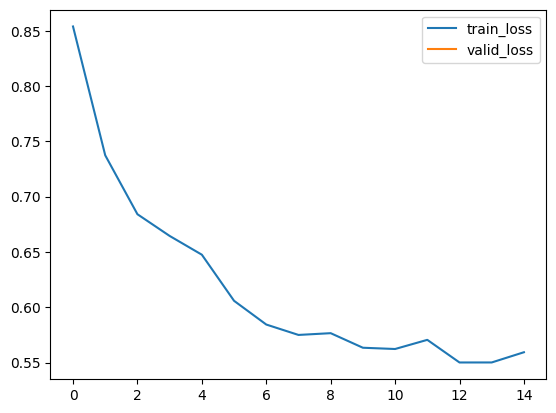

In [8]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

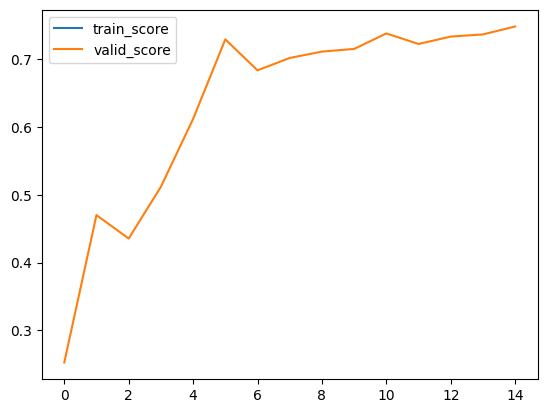

In [9]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [10]:
random.random()

0.5204062747232513